# From raw text to understanding.

### An NLP workshop by Mouad Hadji - [@itismouad](https://twitter.com/itismouad), Lead Data Scientist at Tesla

This code is showcase of the diverse *natural language processing* techniques one can use to :
- automatically classify sentences depending on the sentiment or category
- extract representation of words and sentences to understand text
- etc.

**Disclaimer** : it has been used for a conference workshop, and does not reflect best coding practices

## 0. loading packages

In [1]:
import os, sys
import codecs
import gensim
import pickle
import nltk
import string
import random
import sqlite3
import time
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
'''Reproducibility settings'''
random.seed(100)

## 1. loading and quick inspection of data

We start here by loading our dataset stored in a sqlite database and inspect very quickly. We also load the config path where we will store any (hyper-)parameters or parameters we will be willing to use later in our code.

In [3]:
data_path = '../data'
model_path = '../model'
#config_path = '../config'

### 👉 quick description

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories. As a reminder it can be found [here](https://www.kaggle.com/snap/amazon-fine-food-reviews) on kaggle or [here](http://snap.stanford.edu/data/web-FineFoods.html) on SNAP (original source).

This dataset consists of a single table, **Reviews**.

In [4]:
con = sqlite3.connect(os.path.join(data_path, 'database.sqlite'))
cursor = con.cursor()

In [5]:
%time table = pd.read_sql_query("SELECT * FROM Reviews where Score <> 3;", con)

CPU times: user 3.59 s, sys: 1.4 s, total: 4.99 s
Wall time: 7.36 s


In [6]:
table.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### 👉 perfect showcase

The columns in the table are:

- `Id`
- `ProductId` - unique identifier for the product
- `UserId` - unqiue identifier for the user
- `ProfileName`
- `HelpfulnessNumerator` - number of users who found the review helpful
- `HelpfulnessDenominator` - number of users who indicated whether they found the review helpful
- `Score` - rating between 1 and 5
- `Time` - timestamp for the review
- `Summary` - brief summary of the review
- `Text` - text of the review


This is a perfect example of dataset that a business might be able to gather by sending survey to its customers. We have a `Score` that we can use to create sentiment categories (positive/neutral/negative) and we have a free-text field `Text` where customers can freely enter a review. Data will probably be *messy* and unbalanced (like usual), hence the perfect showcase here.

In [7]:
table.describe()

Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  525814.000000         525814.000000           525814.000000   
mean   284599.060038              1.747293                2.209544   
std    163984.038077              7.575819                8.195329   
min         1.000000              0.000000                0.000000   
25%    142730.250000              0.000000                0.000000   
50%    284989.500000              0.000000                1.000000   
75%    426446.750000              2.000000                2.000000   
max    568454.000000            866.000000              878.000000   

               Score          Time  
count  525814.000000  5.258140e+05  
mean        4.279148  1.295943e+09  
std         1.316725  4.828129e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.270598e+09  
50%         5.000000  1.310861e+09  
75%         5.000000  1.332634e+09  
max         5.000000  1.351210e+09

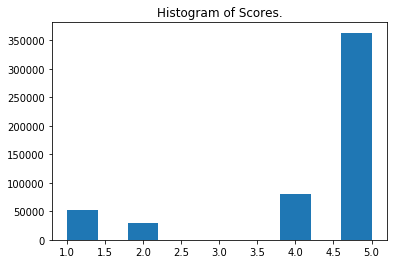

In [8]:
plt.hist(table.Score)
plt.title("Histogram of Scores.")
plt.show()

### 👉 preparing for sentiment classification

We can assume that a score of 4 or greater is *Positive* and that a score lower than 3 strictly is *Negative*. The rest will be *Neutral*

In [9]:
def assign_sentiment(score, label=False):
    if score > 3:
        return "Positive" if not label else 1
    elif score < 3:
        return "Negative" if not label else 2
    else:
        return "Neutral" if not label else 3

In [10]:
table['Sentiment'] = table.Score.apply(assign_sentiment)
table['ClassLabel'] = table.Score.apply(assign_sentiment, label=True)

In [11]:
table.Sentiment.value_counts()

Positive    443777
Negative     82037
Name: Sentiment, dtype: int64

As predicted, the dataset is completely imbalanced. We will balance it later probably by sub-sampling here but we can also make use of different sampling techniques such as SMOTE (see the [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/) package for more detailed and this paper on [SMOTE](https://www.jair.org/media/953/live-953-2037-jair.pdf)).

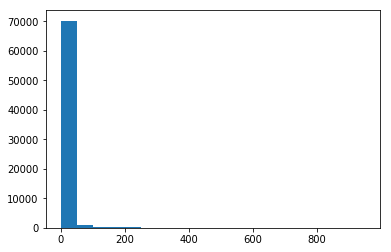

In [12]:
plt.hist([table.ProductId.value_counts()], bins=np.arange(0,1000,50))
plt.show()

In [13]:
data = table[['ProductId', 'Score', 'Summary', 'Text', 'Sentiment', 'ClassLabel']]

In [14]:
data.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  
0  I have bought several of the Vitality canned d...  Positive           1  
1  Product arrived labeled as Jumbo Salted Peanut...  Negative           2  
2  This is a confection that has been around a fe...  Positive           1  
3  If you are looking for the secret ingredient i...  Negative           2  
4  Great taffy at a great price.  There was a wid...  Positive           1

We can now decide to focus only on the relevant columns and dump the rest.

In [15]:
data.to_csv(os.path.join(data_path, 'data_raw.csv'))

## 2. transform the data

### 👉 sanitizing the data

Now that we have our dataset , we want to make sure our reviews only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #onasugardiet)

In [16]:
def sanitize_data(data_path, filename):
    input_file = codecs.open(os.path.join(data_path, filename + '.csv'), "r", encoding='utf-8', errors='replace')
    output_file = open(os.path.join(data_path, filename + '_clean.csv'), "w")

    def sanitize_characters(raw, clean):    
        for line in input_file:
            out = line
            output_file.write(line)

    return sanitize_characters(input_file, output_file)

In [17]:
sanitize_data(data_path, 'data_raw')

We can now reload the data.

In [18]:
data = pd.read_csv(
    open(os.path.join(data_path, 'data_raw_clean.csv'), 'r'),
    index_col = 'Unnamed: 0',
    error_bad_lines=False,
    engine='c')

In [19]:
data.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  
0  I have bought several of the Vitality canned d...  Positive           1  
1  Product arrived labeled as Jumbo Salted Peanut...  Negative           2  
2  This is a confection that has been around a fe...  Positive           1  
3  If you are looking for the secret ingredient i...  Negative           2  
4  Great taffy at a great price.  There was a wid...  Positive           1

### 👉 cleaning the data

Like we often say, "garbage in, garbage out". This is very true in the data science field when it comes to using machine learning or any techniques to play with data. In order to clean the data, we will here using several techniques to come up with a *cleaner* text. **A clean dataset will allow a model to learn meaningful features and not overfit on irrelevant noise.**

Let's grab only 3 sentences to explain the pipeline.

In [20]:
text_test = data.Text.loc[59:62].tolist()
text_test

['This product serves me well as a source of electrolytes during and after a long run or bike ride.<br />I have tried all of the flavors but really do like the grapefruit flavor... no after-taste and I actually like the slight carbonation.<br />I use other Hammer products and really like their whole product line.',
 "This stuff really works for preventing cramping during the middle to latter stages of your rides. Pop 1 into each water bottle and you're set. Flavor is fine and goes down easy.",
 'For those of us on a low carb diet these little tablets are just the thing.<br /><br />Two years ago I started cycling again after many years but was having heart arrhythmia after longer rides in high heat.  I was drinking plain water but did a little research and thought electrolytes might be the issue.  Gatorade wasn\'t an option because it is so loaded with carbohydrates so I looked around for a low-carb alternative.  The "zero carb" sports drinks didn\'t help so what to do?  One day I ran a


- We first want to compress punctuation characters to be able later on to split our text by sentences. 

In [21]:
import re

# compress characters
def compress_characters(text):
    return re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", text)

In [22]:
pipeline_test = [compress_characters(x) for x in text_test]
pipeline_test

['This product serves me well as a source of electrolytes during and after a long run or bike ride.<br />I have tried all of the flavors but really do like the grapefruit flavor. no after-taste and I actually like the slight carbonation.<br />I use other Hammer products and really like their whole product line.',
 "This stuff really works for preventing cramping during the middle to latter stages of your rides. Pop 1 into each water bottle and you're set. Flavor is fine and goes down easy.",
 'For those of us on a low carb diet these little tablets are just the thing.<br /><br />Two years ago I started cycling again after many years but was having heart arrhythmia after longer rides in high heat.  I was drinking plain water but did a little research and thought electrolytes might be the issue.  Gatorade wasn\'t an option because it is so loaded with carbohydrates so I looked around for a low-carb alternative.  The "zero carb" sports drinks didn\'t help so what to do?  One day I ran acr

- We can now move onto the removal of special characters and on the standardization of our free-text data.

In [23]:
def standardize_text(text):
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"@\S+", "")
    text = text.replace("\\", "")
    text = text.replace("/", "")
    text = text.replace(r"[^A-Za-z0-9(),*!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")
    text = text.lower()
    return text

In [24]:
pipeline_test = [standardize_text(x) for x in pipeline_test]
pipeline_test

['this product serves me well as a source of electrolytes during and after a long run or bike ride.<br >i have tried all of the flavors but really do like the grapefruit flavor. no after-taste and i actually like the slight carbonation.<br >i use other hammer products and really like their whole product line.',
 "this stuff really works for preventing cramping during the middle to latter stages of your rides. pop 1 into each water bottle and you're set. flavor is fine and goes down easy.",
 'for those of us on a low carb diet these little tablets are just the thing.<br ><br >two years ago i started cycling again after many years but was having heart arrhythmia after longer rides in high heat.  i was drinking plain water but did a little research and thought electrolytes might be the issue.  gatorade wasn\'t an option because it is so loaded with carbohydrates so i looked around for a low-carb alternative.  the "zero carb" sports drinks didn\'t help so what to do?  one day i ran across 

- We still have many weid characters but the data is getting cleaner. It is now time to split our comments in separate sentences and then tokenize our sentences to a list of separate words.

In [25]:
try:
    nltk.data.find('tokenizers/punkt')

except LookupError:

    nltk.download('punkt')

In [26]:
from nltk import sent_tokenize

pipeline_test = [sent_tokenize(x) for x in pipeline_test]
pipeline_test

[['this product serves me well as a source of electrolytes during and after a long run or bike ride.<br >i have tried all of the flavors but really do like the grapefruit flavor.',
  'no after-taste and i actually like the slight carbonation.<br >i use other hammer products and really like their whole product line.'],
 ['this stuff really works for preventing cramping during the middle to latter stages of your rides.',
  "pop 1 into each water bottle and you're set.",
  'flavor is fine and goes down easy.'],
 ['for those of us on a low carb diet these little tablets are just the thing.<br ><br >two years ago i started cycling again after many years but was having heart arrhythmia after longer rides in high heat.',
  'i was drinking plain water but did a little research and thought electrolytes might be the issue.',
  "gatorade wasn't an option because it is so loaded with carbohydrates so i looked around for a low-carb alternative.",
  'the "zero carb" sports drinks didn\'t help so wha

In [27]:
from nltk.tokenize import RegexpTokenizer

# tokrenize sentences
def tokenize(comment):
    tokenizer = RegexpTokenizer(r'\w+')
    try:
        tokens = tokenizer.tokenize(comment)
        return tokens
    except:
        return 'NC'

In [28]:
pipeline_test = [[tokenize(x) for x in text] for text in pipeline_test]

In [29]:
_ = [print(x) for x in pipeline_test]

[['this', 'product', 'serves', 'me', 'well', 'as', 'a', 'source', 'of', 'electrolytes', 'during', 'and', 'after', 'a', 'long', 'run', 'or', 'bike', 'ride', 'br', 'i', 'have', 'tried', 'all', 'of', 'the', 'flavors', 'but', 'really', 'do', 'like', 'the', 'grapefruit', 'flavor'], ['no', 'after', 'taste', 'and', 'i', 'actually', 'like', 'the', 'slight', 'carbonation', 'br', 'i', 'use', 'other', 'hammer', 'products', 'and', 'really', 'like', 'their', 'whole', 'product', 'line']]
[['this', 'stuff', 'really', 'works', 'for', 'preventing', 'cramping', 'during', 'the', 'middle', 'to', 'latter', 'stages', 'of', 'your', 'rides'], ['pop', '1', 'into', 'each', 'water', 'bottle', 'and', 'you', 're', 'set'], ['flavor', 'is', 'fine', 'and', 'goes', 'down', 'easy']]
[['for', 'those', 'of', 'us', 'on', 'a', 'low', 'carb', 'diet', 'these', 'little', 'tablets', 'are', 'just', 'the', 'thing', 'br', 'br', 'two', 'years', 'ago', 'i', 'started', 'cycling', 'again', 'after', 'many', 'years', 'but', 'was', 'hav

- Good. Additional cleaning can be done by removing stop words and other miscellaneous characters.

In [30]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_tokens(token_list, stop_words):
    filtered_tokens = token_list
    filtered_tokens = [word for word in token_list if word not in stop_words]
    filtered_tokens = [''.join(c for c in s if c not in string.punctuation) for s in filtered_tokens]
    filtered_tokens = [s for s in filtered_tokens if s]
    return filtered_tokens

In [31]:
pipeline_test = [[clean_tokens(x, stop_words) for x in text] for text in pipeline_test]

In [32]:
_ = [print(x) for x in pipeline_test]

[['product', 'serves', 'well', 'source', 'electrolytes', 'long', 'run', 'bike', 'ride', 'br', 'tried', 'flavors', 'really', 'like', 'grapefruit', 'flavor'], ['taste', 'actually', 'like', 'slight', 'carbonation', 'br', 'use', 'hammer', 'products', 'really', 'like', 'whole', 'product', 'line']]
[['stuff', 'really', 'works', 'preventing', 'cramping', 'middle', 'latter', 'stages', 'rides'], ['pop', '1', 'water', 'bottle', 'set'], ['flavor', 'fine', 'goes', 'easy']]
[['us', 'low', 'carb', 'diet', 'little', 'tablets', 'thing', 'br', 'br', 'two', 'years', 'ago', 'started', 'cycling', 'many', 'years', 'heart', 'arrhythmia', 'longer', 'rides', 'high', 'heat'], ['drinking', 'plain', 'water', 'little', 'research', 'thought', 'electrolytes', 'might', 'issue'], ['gatorade', 'option', 'loaded', 'carbohydrates', 'looked', 'around', 'low', 'carb', 'alternative'], ['zero', 'carb', 'sports', 'drinks', 'help'], ['one', 'day', 'ran', 'across', 'bike', 'shop', 'tried', 'tube', 'voila', 'problem', 'solved',

- We could stop here but we will take it a bit further. You can notice that at this point `enjoy` and `enjoyed` won't be represented by the same word. However, at some point later in this notebook, we might want to consider them as having exactly the same meaning. For this purpose, we will lemmatize our tokens as following :

In [33]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

# lemmatize words
def lemmatize_tokens(token_list):
    token_lemmatized = [WordNetLemmatizer().lemmatize(word,'v') for word in token_list]
    token_processed = [wordnet.morphy(word) for word in token_lemmatized]
    token_processed_final = [word for word in token_processed if word is not None]
    return token_processed_final

In [34]:
pipeline_test = [[lemmatize_tokens(x) for x in text] for text in pipeline_test]

In [35]:
_ = [print(x) for x in pipeline_test]

[['product', 'serve', 'well', 'source', 'electrolyte', 'long', 'run', 'bike', 'ride', 'br', 'try', 'flavor', 'really', 'like', 'grapefruit', 'flavor'], ['taste', 'actually', 'like', 'slight', 'carbonation', 'br', 'use', 'hammer', 'product', 'really', 'like', 'whole', 'product', 'line']]
[['stuff', 'really', 'work', 'prevent', 'cramp', 'middle', 'latter', 'stag', 'rid'], ['pop', '1', 'water', 'bottle', 'set'], ['flavor', 'fine', 'go', 'easy']]
[['us', 'low', 'diet', 'little', 'tablet', 'thing', 'br', 'br', 'two', 'years', 'ago', 'start', 'cycle', 'many', 'years', 'heart', 'arrhythmia', 'longer', 'rid', 'high', 'heat'], ['drink', 'plain', 'water', 'little', 'research', 'think', 'electrolyte', 'might', 'issue'], ['option', 'load', 'carbohydrate', 'look', 'around', 'low', 'alternative'], ['zero', 'sport', 'drink', 'help'], ['one', 'day', 'run', 'across', 'bike', 'shop', 'try', 'tube', 'problem', 'solve', 'br', 'br', 'share', 'two', 'friend', 'particular', 'problem', 'leg', 'cramp', 'resolv

The token lists look nothing like the initial but we have now several degrees of processing that we can use and try for our tasks.

We introduce here the `transform_data` function that runs all the tranformations listed above. It then creates 3 new columns:
- `tokens` : clean tokens
- `tokens_clean` : clean tokens without stopwords
- `tokens_lemme` : clean lemmatized tokens without stopwords

In [36]:
def transform_data(data, text_field, stop_words):
    print('Compressing characters...')
    data[text_field] = data[text_field].apply(compress_characters)
    print('Standardizing text...')
    data[text_field] = data[text_field].apply(standardize_text)
    print('Splitting sentences...')
    data['list_sentences'] = data[text_field].apply(sent_tokenize)
    print('Tokenizing text...')
    data['tokens'] = data['list_sentences'].apply(lambda x : [tokenize(text) for text in x])
    print('Cleaning tokens...')
    data['tokens_clean'] = data['tokens'].apply(lambda x : [clean_tokens(item, stop_words) for item in x if item not in ['NC']])
    print('Lemmatizing tokens...')
    data['tokens_lemme'] = data['tokens_clean'].apply(lambda x : [lemmatize_tokens(item) for item in x])
    return data

In [37]:
%time data_clean = transform_data(data, text_field='Text', stop_words=stop_words)

Compressing characters...
Standardizing text...
Splitting sentences...
Tokenizing text...
Cleaning tokens...
Lemmatizing tokens...
CPU times: user 7min 34s, sys: 11.6 s, total: 7min 46s
Wall time: 7min 49s


If it can be very useful to split tokens by sentences (especially for a classification task), we will simplify our tokens input by flattening our list of tokens :

* `tokens_flat`
* `tokens_clean_flat`
* `tokens_lemme_flat`

In [38]:
def flatten_tokens(df, syntaxes):
    for i in range(len(syntaxes)):
        df['tokens' + syntaxes[i] + '_flat'] = df['tokens' + syntaxes[i]].apply(lambda list_token : [item for sublist in list_token for item in sublist])
    return df

In [39]:
syntaxes = ['', '_clean', '_lemme']

In [40]:
%time data_clean = flatten_tokens(data_clean, syntaxes)

CPU times: user 11.9 s, sys: 5.78 s, total: 17.6 s
Wall time: 18.3 s


In [41]:
data_clean.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  \
0  i have bought several of the vitality canned d...  Positive           1   
1  product arrived labeled as jumbo salted peanut...  Negative           2   
2  this is a confection that has been around a fe...  Positive           1   
3  if you are looking for the secret ingredient i...  Negative           2   
4  great taffy at a great price.  there was a wid...  Positive           1   

                                      list_sentences  \
0  [i have bought several of the vitality canned ...   
1  [product arrived labeled as jumbo salted peanu...   
2  [this is a confection that has been around a f...   
3  [if you are looking for the secret ingredient ...   
4  [great taffy at a great price., there was a wi...   

                                              tokens  \
0  [[i, have, bought, several, of, the, vitality,...   
1  [[product, arrived, labeled, as, jumbo, salted...   
2  [[this, is, a, confection, that, has, been, ar...   
3  [[if, you, are, looking, for, the, secret, ing...   
4  [[great, taffy, at, a, great, price], [there, ...   

                                        tokens_clean  \
0  [[bought, several, vitality, canned, dog, food...   
1  [[product, arrived, labeled, jumbo, salted, pe...   
2  [[confection, around, centuries], [light, pill...   
3  [[looking, secret, ingredient, robitussin, bel...   
4  [[great, taffy, great, price], [wide, assortme...   

                                        tokens_lemme  \
0  [[buy, several, vitality, can, dog, food, prod...   
1  [[product, arrive, label, jumbo, salt, peanuts...   
2  [[confection, around, century], [light, citrus...   
3  [[look, secret, ingredient, robitussin, believ...   
4  [[great, taffy, great, price], [wide, assortme...   

                                         tokens_flat  \
0  [i, have, bought, several, of, the, vitality, ...   
1  [product, arrived, labeled, as, jumbo, salted,...   
2  [this, is, a, confection, that, has, been, aro...   
3  [if, you, are, looking, for, the, secret, ingr...   
4  [great, taffy, at, a, great, price, there, was...   

                                   tokens_clean_flat  \
0  [bought, several, vitality, canned, dog, food,...   
1  [product, arrived, labeled, jumbo, salted, pea...   
2  [confection, around, centuries, light, pillowy...   
3  [looking, secret, ingredient, robitussin, beli...   
4  [great, taffy, great, price, wide, assortment,...   

                                   tokens_lemme_flat  
0  [buy, several, vitality, can, dog, food, produ...  
1  [product, arrive, label, jumbo, salt, peanuts,...  
2  [confection, around, century, light, citrus, g...  
3  [look, secret, ingredient, robitussin, believe...  
4  [great, taffy, great, price, wide, assortment,...

In [42]:
pos_data = data_clean.query("Sentiment=='Positive'")
neg_data = data_clean.query("Sentiment=='Negative'")

## 3. summary statistics

Let's look at few statistics on our dataset like the total number of words (vocabulary), the distribution of sentence lengths, etc.

In [43]:
all_words, all_words_clean, all_words_lemme = [[word for tokens in data_clean['tokens' + syntax + '_flat'] for word in tokens] for syntax in syntaxes]
sentence_lengths, sentence_lengths_clean, sentence_lengths_lemme = [[len(tokens) for tokens in data_clean['tokens' + syntax + '_flat']] for syntax in syntaxes]
VOCAB, VOCAB_CLEAN, VOCAB_LEMME = [sorted(list(set(all_words))) for all_words in [all_words, all_words_clean, all_words_lemme]] 

In [44]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words), 'tokens', len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

42951013 words total for tokens, with a vocabulary size of 130441
Max sentence length is 2616


In [45]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words_clean), 'clean tokens', len(VOCAB_CLEAN)))
print("Max sentence length is %s" % max(sentence_lengths_clean))

21553196 words total for clean tokens, with a vocabulary size of 130130
Max sentence length is 1702


In [46]:
print("%s words total for %s, with a vocabulary size of %s" % (len(all_words_lemme), 'lemmatized tokens', len(VOCAB_LEMME)))
print("Max sentence length is %s" % max(sentence_lengths_lemme))

20312839 words total for lemmatized tokens, with a vocabulary size of 26523
Max sentence length is 1511


#### vocabulary

In [47]:
LABELS = ['tokens' + syntax for syntax in syntaxes]

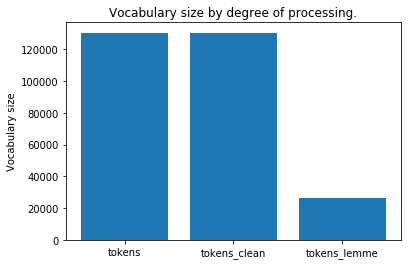

In [48]:
plt.bar(range(3), [len(VOCAB), len(VOCAB_CLEAN), len(VOCAB_LEMME)])
plt.xticks(range(3), LABELS)
plt.ylabel('Vocabulary size')
plt.xlabel('')
plt.title('Vocabulary size by degree of processing.')
plt.show()

#### sentence lengths

In [49]:
pd.Series(sentence_lengths).describe()

count    525814.000000
mean         81.684803
std          81.712803
min           3.000000
25%          34.000000
50%          57.000000
75%          99.000000
max        2616.000000
dtype: float64

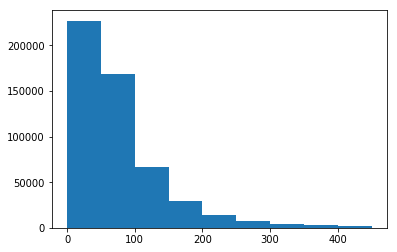

In [50]:
plt.hist(sentence_lengths, bins=np.arange(0, 500, 50))
plt.show()

In [51]:
sentence_lengths_pos = [len(tokens) for tokens in pos_data['tokens_flat']]
sentence_lengths_neg = [len(tokens) for tokens in neg_data['tokens_flat']]
sentence_lengths_all = [sentence_lengths_pos, sentence_lengths_neg]

In [52]:
print([np.mean(sen) for sen in sentence_lengths_all])
print([np.median(sen) for sen in sentence_lengths_all])

[79.90117108367491, 91.33331301729707]
[55.0, 66.0]


In [53]:
def show_plots(data_pts, n_row=1, n_col=3, figsize=(15, 6), title_name='Histogram'):
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    n_pts = n_row*n_col
    data_pts = data_pts[:n_pts]
    
    for i, data_pt in enumerate(data_pts):
        plt.subplot(n_row, n_col, i+1)
        plt.hist(data_pt, bins=np.arange(0,500,25))
        plt.title(title_name, fontsize=10)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)

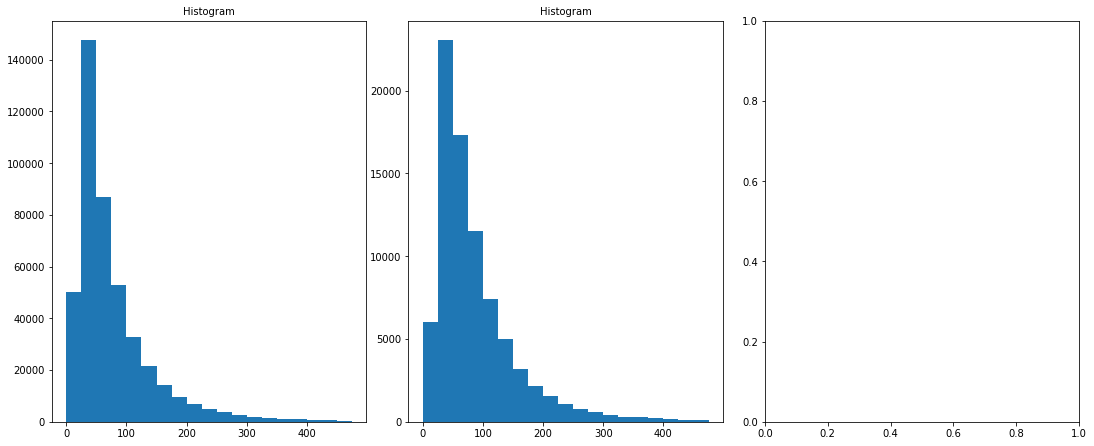

In [54]:
show_plots(sentence_lengths_all)

## 4. word embeddings

We want to capture the semantic meaning of words, meaning we need to understand that words like ‘good’ and ‘positive’ are closer than ‘apricot’ and ‘continent.’ The tool we will use to help us capture meaning is called Word2Vec.

Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers.

**Using pre-trained words**

Word2Vec is a technique to find continuous embeddings for words. It learns from reading massive amounts of text and memorizing which words tend to appear in similar contexts. After being trained on enough data, it generates a 300-dimension vector for each word in a vocabulary, with words of similar meaning being closer to each other.

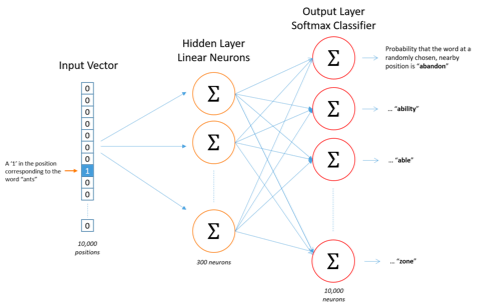

In [55]:
Image(filename='../img/skip_gram.png')

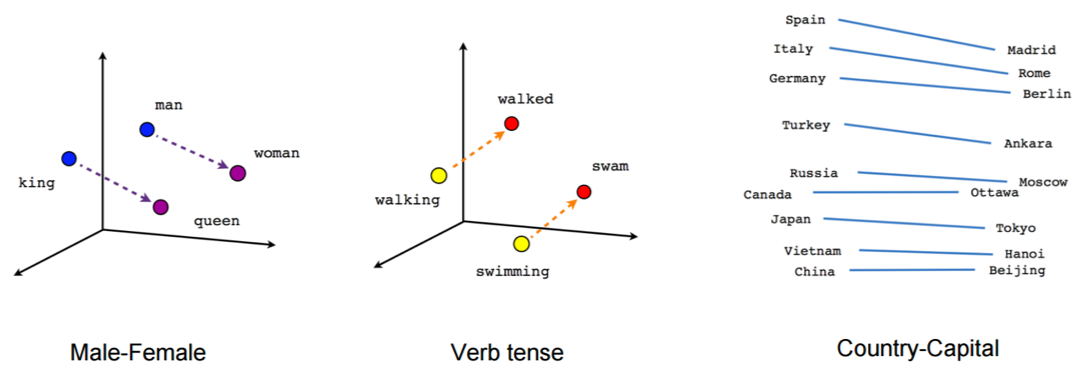

In [56]:
Image(filename='../img/w2v.png')

In [57]:
EMBEDDING_DIM=300

### 4.a. load word2vec (Google)

In [58]:
wor2vec_path = os.path.join(data_path, 'word2vec/GoogleNews-vectors-negative300.bin.gz')
word2vec = gensim.models.KeyedVectors.load_word2vec_format(wor2vec_path, binary=True)

### 4.b. load glove

In [59]:
def load_glove(glove_path):
    f = open(glove_path,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = [float(val) for val in splitLine[1:]]
        model[word] = embedding
    return model

In [60]:
%%time
glove_path = os.path.join(data_path, 'glove/glove.6B.300d.txt')

glove = load_glove(glove_path)

CPU times: user 36.5 s, sys: 2.93 s, total: 39.5 s
Wall time: 40.1 s


### 4.c. load word2vec (custom-made)

In [61]:
from gensim.models.word2vec import Word2Vec

# train custom-made word2vec
def train_word2vec_model(n_dim, min_count, list_sentences, corpus_size, epochs):
    vec_model = Word2Vec(size=n_dim, min_count=min_count)
    vec_model.build_vocab(list_sentences)
    vec_model.train(list_sentences, total_examples=corpus_size, epochs=epochs)
    return vec_model

In [62]:
cols = ['tokens' + syntax + '_flat' for syntax in syntaxes]
cols

['tokens_flat', 'tokens_clean_flat', 'tokens_lemme_flat']

In [63]:
w2v_custom = [train_word2vec_model(n_dim=EMBEDDING_DIM, min_count=10, list_sentences=list(data_clean[col]), corpus_size=len(all_words), epochs=10) for col in cols]

### 4.d. benchmark and visualize

In [64]:
embeddings_labels = ['w2v', 'amz', 'glv']

In [65]:
embedding_dict = {'w2v':word2vec, 'amz':w2v_custom, 'glv':glove}
embedding_dict_simple = {'w2v':word2vec, 'amz':w2v_custom[2], 'glv':glove}

In [66]:
def get_average_word2vec(tokens_list, w2v, generate_missing=False, k=300):

    if len(tokens_list) < 1:
        return np.zeros(k)

    if generate_missing:
        vectorized = [w2v[word] if word in w2v else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [w2v[word] if word in w2v else np.zeros(k) for word in tokens_list]

    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    return averaged

In [67]:
def average_vectors(vectors, k=300):
    length = len(vectors)
    if length > 0:
        try:
            summed = np.sum(vectors, axis=0)
            averaged = np.divide(summed, length)
        except:
            averaged = np.zeros(k)
    else:
        averaged = np.zeros(k)
    return averaged

In [68]:
def get_word2vec_embeddings(embedding_representation, list_sentences, flat=False, generate_missing=False):
    embeddings = [get_average_word2vec(sublist, embedding_representation, generate_missing=generate_missing) for sublist in list_sentences]
    if not flat:
        embeddings = average_vectors(embeddings)
    return embeddings

In [69]:
def add_embedding(df, embedding_representation, output_prefix, flat=False, generate_missing=False):
    df[output_prefix] = df['tokens'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    df[output_prefix + '_clean'] = df['tokens_clean'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    df[output_prefix + '_lemme'] = df['tokens_lemme'].apply(lambda x: get_word2vec_embeddings(embedding_representation, x, flat, generate_missing))
    return df

In [70]:
def add_data_embeddings(df, embedding_dict, flat=False, generate_missing=False):
    for key, value in embedding_dict.items():
        print(' -- Adding ' + key +  ' embedding -- ')
        df = add_embedding(df, value, key)
    return df

In [71]:
data_clean = add_data_embeddings(data_clean, embedding_dict_simple)

 -- Adding w2v embedding -- 
 -- Adding amz embedding -- 
 -- Adding glv embedding -- 


In [72]:
data_clean.head()

ProductId  Score                Summary  \
0  B001E4KFG0      5  Good Quality Dog Food   
1  B00813GRG4      1      Not as Advertised   
2  B000LQOCH0      4  "Delight" says it all   
3  B000UA0QIQ      2         Cough Medicine   
4  B006K2ZZ7K      5            Great taffy   

                                                Text Sentiment  ClassLabel  \
0  i have bought several of the vitality canned d...  Positive           1   
1  product arrived labeled as jumbo salted peanut...  Negative           2   
2  this is a confection that has been around a fe...  Positive           1   
3  if you are looking for the secret ingredient i...  Negative           2   
4  great taffy at a great price.  there was a wid...  Positive           1   

                                      list_sentences  \
0  [i have bought several of the vitality canned ...   
1  [product arrived labeled as jumbo salted peanu...   
2  [this is a confection that has been around a f...   
3  [if you are looking for the secret ingredient ...   
4  [great taffy at a great price., there was a wi...   

                                              tokens  \
0  [[i, have, bought, several, of, the, vitality,...   
1  [[product, arrived, labeled, as, jumbo, salted...   
2  [[this, is, a, confection, that, has, been, ar...   
3  [[if, you, are, looking, for, the, secret, ing...   
4  [[great, taffy, at, a, great, price], [there, ...   

                                        tokens_clean  \
0  [[bought, several, vitality, canned, dog, food...   
1  [[product, arrived, labeled, jumbo, salted, pe...   
2  [[confection, around, centuries], [light, pill...   
3  [[looking, secret, ingredient, robitussin, bel...   
4  [[great, taffy, great, price], [wide, assortme...   

                                        tokens_lemme  \
0  [[buy, several, vitality, can, dog, food, prod...   
1  [[product, arrive, label, jumbo, salt, peanuts...   
2  [[confection, around, century], [light, citrus...   
3  [[look, secret, ingredient, robitussin, believ...   
4  [[great, taffy, great, price], [wide, assortme...   

                         ...                          \
0                        ...                           
1                        ...                           
2                        ...                           
3                        ...                           
4                        ...                           

                                   tokens_lemme_flat  \
0  [buy, several, vitality, can, dog, food, produ...   
1  [product, arrive, label, jumbo, salt, peanuts,...   
2  [confection, around, century, light, citrus, g...   
3  [look, secret, ingredient, robitussin, believe...   
4  [great, taffy, great, price, wide, assortment,...   

                                                 w2v  \
0  [-0.022584969656808035, 0.023657135736374627, ...   
1  [-0.0014004177517361119, 0.05075030856662326, ...   
2  [0.009928270430303181, 0.0001300514286183647, ...   
3  [0.0054677324990431465, 0.037639387696981434, ...   
4  [0.0562803480360243, 0.011174307929144967, -0....   

                                           w2v_clean  \
0  [-0.051966477, 0.0710083, -0.022050349, 0.0916...   
1  [-0.040326007, 0.054383215, 0.08292419, 0.1525...   
2  [0.004053620013027367, -0.016334780767052012, ...   
3  [0.005100504495203495, 0.06380140491657788, 0....   
4  [0.085365295, 0.01118215, -0.0672493, 0.166198...   

                                           w2v_lemme  \
0  [-0.03971977, 0.0654419, -0.028363928, 0.12114...   
1  [-0.03017911, 0.040574208, 0.059624612, 0.1574...   
2  [-0.0028515225, -0.033921596, 0.01948769, 0.11...   
3  [-0.009714762369791666, 0.05305107951992088, 0...   
4  [0.085365295, 0.01118215, -0.0672493, 0.166198...   

                                                 amz  \
0  [0.1322649139513646, 0.06927512695805894, 0.13...   
1  [-0.031346812807319185, 0.09465198842660774, 0...   
2  [0.06474733850676134, -0.00665222664731187, -0..

In [73]:
embeddings_w2v, embeddings_amz, embeddings_glv = [data_clean[col + '_clean'].tolist() for col in embeddings_labels]

In [74]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

%matplotlib inline
from pylab import *

In [75]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    print(color_mapper)
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['green','blue', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        green_patch = mpatches.Patch(color='green', label='Positive')
        red_patch = mpatches.Patch(color='red', label='Negative')
        #blue_patch = mpatches.Patch(color='blue', label='Neutral')
        plt.legend(handles=[green_patch, red_patch])#, blue_patch])

In [76]:
x=embeddings_amz
y=data_clean.ClassLabel.tolist()

In [77]:
data_clean.Sentiment.value_counts()

Positive    443777
Negative     82037
Name: Sentiment, dtype: int64

{1: 0, 2: 1}


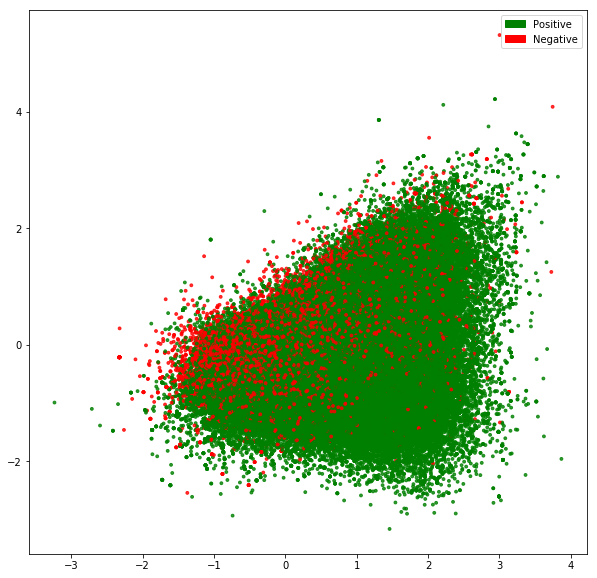

In [78]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(x, y)
plt.show()

## 5. balance dataset

In [79]:
output_label = 'Sentiment'

In [80]:
def balance_dataset(df, output_label, sampling_type):
    
    unique_outputs = list(set(df[output_label].tolist()))

    datasets = [df.loc[df[output_label]==item] for item in unique_outputs]
    sizes = [item.shape[0] for item in datasets]
    min_size = min(sizes)
    max_size = max(sizes)

    if sampling_type=="over":
        result_df = pd.concat([data.sample(max_size, replace=True) for data in datasets])
    elif sampling_type=="down":
        result_df = pd.concat([data.sample(min_size) for data in datasets])
        
    result_df.reset_index(drop=True, inplace=True)
    return result_df

In [81]:
balanced_data_clean = balance_dataset(data_clean, output_label, sampling_type="down")

In [82]:
print('Balanced dataset shape :', balanced_data_clean.shape)

Balanced dataset shape : (164074, 22)


In [83]:
balanced_data_clean.Sentiment.value_counts()

Positive    82037
Negative    82037
Name: Sentiment, dtype: int64

In [84]:
balanced_data_clean = balanced_data_clean.loc[balanced_data_clean.Sentiment!='Neutral']
balanced_data_clean.reset_index(drop=True, inplace=True)
balanced_data_clean.Sentiment.value_counts()

Positive    82037
Negative    82037
Name: Sentiment, dtype: int64

In [85]:
embeddings_w2v_blcd, embeddings_amz_blcd, embeddings_glv_blcd = [balanced_data_clean[col + '_clean'].tolist() for col in embeddings_labels]

In [86]:
x=embeddings_amz_blcd
y=balanced_data_clean.ClassLabel.tolist()

In [87]:
w2v_custom[2].most_similar('car')

[('backpack', 0.49182137846946716),
 ('purse', 0.4778805375099182),
 ('stroller', 0.4650011658668518),
 ('plane', 0.4610077738761902),
 ('briefcase', 0.432492196559906),
 ('motorcycle', 0.43099918961524963),
 ('luggage', 0.41634297370910645),
 ('handbag', 0.4100511968135834),
 ('diaper', 0.4075238108634949),
 ('airplane', 0.3974236845970154)]

## 6. Classification tasks

**Vectors** : 
- `X_w2v`
- `X_amz`
- `X_glv`

**Labels** :
- `y`

In [88]:
X_w2v, X_amz, X_glv = [balanced_data_clean[col + '_lemme'].tolist() for col in embeddings_labels]
y = balanced_data_clean.ClassLabel.tolist()

In [89]:
from sklearn.model_selection import train_test_split

def generate_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    return X_train, X_test, y_train, y_test

In [90]:
X_w2v_train, X_w2v_test, y_train, y_test = generate_data(X_w2v, y)
X_amz_train, X_amz_test, _, _ = generate_data(X_amz, y)
X_glv_train, X_glv_test, _, _ = generate_data(X_glv, y)

### 6.a Starting simple : Logistic Regression and SVM

In [91]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

% time clf.fit(X_w2v_train, y_train)
y_w2v_predicted = clf.predict(X_w2v_test)

% time clf.fit(X_glv_train, y_train)
y_glv_predicted = clf.predict(X_glv_test)

% time clf.fit(X_amz_train, y_train)
y_amz_predicted = clf.predict(X_amz_test)

CPU times: user 16.6 s, sys: 1min 13s, total: 1min 29s
Wall time: 3min 26s
CPU times: user 16.1 s, sys: 54.6 s, total: 1min 10s
Wall time: 2min 7s
CPU times: user 13.5 s, sys: 36.4 s, total: 49.9 s
Wall time: 1min 19s


In [92]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [93]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_w2v_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.829, precision = 0.829, recall = 0.829, f1 = 0.829


In [94]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_amz_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.859, precision = 0.859, recall = 0.859, f1 = 0.859


In [95]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_glv_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.825, precision = 0.825, recall = 0.825, f1 = 0.825


In [98]:
'''
from sklearn import svm
clf = svm.SVC(kernel='linear', probability=True, random_state=40)

% time clf.fit(X_w2v_train, y_train)
y_w2v_predicted = clf.predict(X_w2v_test)

% time clf.fit(X_amz_train, y_train)
y_amz_predicted = clf.predict(X_amz_test)

% time clf.fit(X_glv_train, y_train)
y_glv_predicted = clf.predict(X_glv_test)
'''

"from sklearn import svm\nclf = svm.SVC(kernel='linear', probability=True, random_state=40)\n\n% time clf.fit(X_w2v_train, y_train)\ny_w2v_predicted = clf.predict(X_w2v_test)\n\n% time clf.fit(X_amz_train, y_train)\ny_amz_predicted = clf.predict(X_amz_test)\n\n% time clf.fit(X_glv_train, y_train)\ny_glv_predicted = clf.predict(X_glv_test)"

In [99]:
#accuracy, precision, recall, f1 = get_metrics(y_test, y_w2v_predicted)
#print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [100]:
#accuracy, precision, recall, f1 = get_metrics(y_test, y_amz_predicted)
#print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [101]:
#accuracy, precision, recall, f1 = get_metrics(y_test, y_glv_predicted)
#print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

### 👉 Let's look at how each model is performing by looking at the confusion matrix

In [102]:
from sklearn.metrics import confusion_matrix
import itertools

cm_w2v = confusion_matrix(y_test, y_w2v_predicted)
cm_amz = confusion_matrix(y_test, y_amz_predicted)
cm_glv = confusion_matrix(y_test, y_glv_predicted)

In [103]:
cm_w2v

array([[13472,  2994],
       [ 2598, 13751]])

In [104]:
cm_amz

array([[14096,  2370],
       [ 2281, 14068]])

In [105]:
cm_glv

array([[13303,  3163],
       [ 2683, 13666]])

### 👉 From now we can inspect further the variables importance and start understanding how our models are classifying comments

In [96]:
balanced_data_clean.ClassLabel.value_counts()

2    82037
1    82037
Name: ClassLabel, dtype: int64

In [97]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(balanced_data_clean.Text,
                                                                        balanced_data_clean.ClassLabel,
                                                                        test_size=0.2,
                                                                        random_state=40)
vector_store = embedding_dict_simple['amz']

def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf.predict_proba(tokenized_list)

#c = make_pipeline(count_vectorizer, clf)

In [98]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Positive","Negative"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]-1])
    exp.show_in_notebook(text=True)

In [99]:
indexes = X_test_data.index

In [100]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

visualize_one_exp(X_test_data, y_test_data, indexes[0])

Index: 28477
True class: Positive


In [101]:
visualize_one_exp(X_test_data, y_test_data, indexes[3])

Index: 133116
True class: Negative


In [102]:
visualize_one_exp(X_test_data, y_test_data, indexes[5])

Index: 124284
True class: Negative


### 6.b Leveraging text structure and deep learning

We’ve covered quick and efficient approaches to generate compact sentence embeddings. However, by omitting the order of words, we are discarding all of the syntactic information of our sentences. If these methods do not provide sufficient results, you can utilize more complex model that take in whole sentences as input and predict labels without the need to build an intermediate representation. A common way to do that is to treat a sentence as a sequence of individual word vectors using either Word2Vec or more recent approaches such as GloVe or CoVe. This is what we will do below.

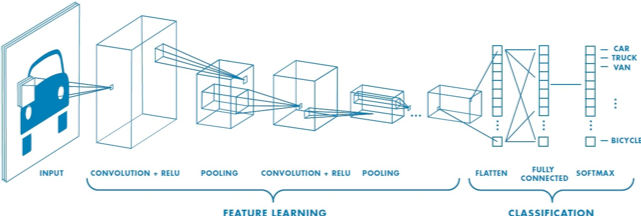

In [104]:
Image(filename='../img/cnn_vision.png')

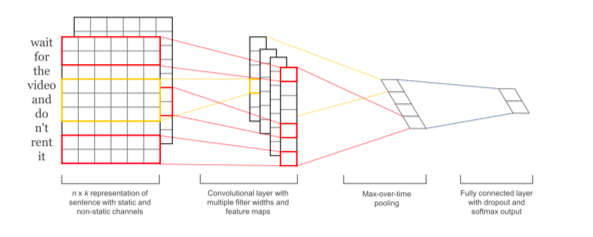

In [105]:
Image(filename='../img/cnn_text.png')

In [106]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(balanced_data_clean["Text"].tolist())
sequences = tokenizer.texts_to_sequences(balanced_data_clean["Text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

balanced_data_clean["NewClassLabel"] = balanced_data_clean["ClassLabel"].map({1:0, 2:1})

labels = to_categorical(np.asarray(balanced_data_clean["NewClassLabel"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word,index in word_index.items():
    embedding_weights[index,:] = embedding_dict_simple['amz'][word] if word in embedding_dict_simple['amz'] else np.random.rand(EMBEDDING_DIM)

print(embedding_weights.shape)

Using TensorFlow backend.


Found 82551 unique tokens.
(82552, 300)


In [107]:
balanced_data_clean["ClassLabel"].value_counts()

2    82037
1    82037
Name: ClassLabel, dtype: int64

In [108]:
balanced_data_clean["NewClassLabel"].value_counts()

1    82037
0    82037
Name: NewClassLabel, dtype: int64

In [109]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        l_pool = Flatten()(l_pool)
        convs.append(l_pool)

    #l_merge = Merge(mode='concat', concat_axis=1)(convs)
    l_merge = Concatenate()(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    #x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [110]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(balanced_data_clean["ClassLabel"].unique())), False)

In [112]:
#model_hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

### 6.c Going further : fasttext

[fastText](https://github.com/facebookresearch/fastText) is a library for efficient learning of word representations and sentence classification developed by Facebook Research

In [114]:
balanced_data_clean.head(2)

ProductId  Score             Summary  \
0  B002HNS55A      5             Tabasco   
1  B001L4CZWA      5  amazon is awesome!   

                                                Text Sentiment  ClassLabel  \
0  fast, great.  everything i was hopping for. i ...  Positive           1   
1  i searched high and low for my cavatappi pasta...  Positive           1   

                                      list_sentences  \
0  [fast, great., everything i was hopping for., ...   
1  [i searched high and low for my cavatappi past...   

                                              tokens  \
0  [[fast, great], [everything, i, was, hopping, ...   
1  [[i, searched, high, and, low, for, my, cavata...   

                                        tokens_clean  \
0  [[fast, great], [everything, hopping], [buy], ...   
1  [[searched, high, low, cavatappi, pasta, even,...   

                                        tokens_lemme      ...       \
0  [[fast, great], [hop], [buy], [next, time, buy...      ...        
1  [[search, high, low, pasta, even, specialty, s...      ...        

                                                 w2v  \
0  [0.032185365, 0.025346374, 0.02818527, 0.13940...   
1  [0.010749138726128473, 0.019412305619981553, -...   

                                           w2v_clean  \
0  [0.07064002, -0.031726293, -0.055780683, 0.164...   
1  [0.052821790954718985, 0.020113990331689518, -...   

                                           w2v_lemme  \
0  [0.03956822, -0.042860847, -0.045805797, 0.197...   
1  [0.05531819555021467, 0.01535150453093506, -0....   

                                                 amz  \
0  [-0.02578828119294485, -0.16412339359521866, -...   
1  [-0.029703424773308344, -0.1615374602239441, -...   

                                           amz_clean  \
0  [-0.1513161864131689, 0.003926300044570646, -0...   
1  [-0.06642192191079313, -0.29489243861574393, 0...   

                                           amz_lemme  \
0  [0.34673357, 0.09811152, -0.08241186, -0.56538...   
1  [-0.027541483, -0.37944004, 0.009229998, -0.04...   

                                                 glv  \
0  [-0.060428169999999996, 0.03415085, 0.01761117...   
1  [-0.12794736620370373, 0.1665703388888889, -0....   

                                           glv_clean  \
0  [0.01816369642857143, -0.02302744642857143, 0....   
1  [-0.15572584432234432, 0.20245309615384613, -0...   

                                           glv_lemme NewClassLabel  
0  [-0.031203982142857134, -0.04316929285714285, ...             0  
1  [-0.20013434285714285, 0.21657807619047617, -0...             0  

[2 rows x 23 columns]

In [115]:
def add_fasttext_columns(df, shuffle=False, label_prefix='__label__'):
    
    if shuffle:
        df.sample(frac=1).reset_index(drop=True)

    df['Sentiment_ft'] = label_prefix + df['Sentiment'].apply(lambda s : "".join(s.split())) + ' '
    df['Comment_clean'] = df['tokens_flat'].apply(lambda x : ' '.join(x))
    df['Comment_ft'] = ' ' + df['Comment_clean'] + ' '
    return df

balanced_data_clean = add_fasttext_columns(balanced_data_clean)

In [116]:
balanced_data_clean[['Comment_ft', 'Sentiment_ft']].head()

Comment_ft        Sentiment_ft
0   fast great everything i was hopping for i wil...  __label__Positive 
1   i searched high and low for my cavatappi past...  __label__Positive 
2   it s hard to find chiclets in the stores the ...  __label__Positive 
3   worked great a good must have for breastfeedi...  __label__Positive 
4   i tried this soan papdi and soan papdi cake f...  __label__Positive

In [117]:
data_labels = ['train', 'test']

In [118]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(balanced_data_clean,
                                                                        balanced_data_clean.ClassLabel,
                                                                        test_size=0.2,
                                                                        random_state=40)

In [121]:
import fasttext

def fit_fasttext():
    data_file_ft = [os.path.join(data_path, '_data_ft.' + data_label) for data_label in data_labels]
    train_file_ft, test_file_ft = data_file_ft
    [x.to_csv(y, header=None, index=False, columns=['Sentiment_ft','Comment_ft']) for x,y in zip([X_train_data, X_test_data], data_file_ft)]
    model_file = os.path.join(model_path, 'fasttext_model')
    classifier = fasttext.supervised(train_file_ft, model_file, dim=30, lr=0.1, epoch=15, min_count=1, word_ngrams=3, bucket=10000000, thread=12, label_prefix='__label__')
    result = classifier.test(test_file_ft)
    f1_score = 2*(result.precision*result.recall)/(result.precision + result.recall)
    print('fasttext F1-score :', f1_score)

In [122]:
fit_fasttext()

fasttext F1-score : 0.9499923815328356


## 7. Final results  🎉

Date: As of first iteration

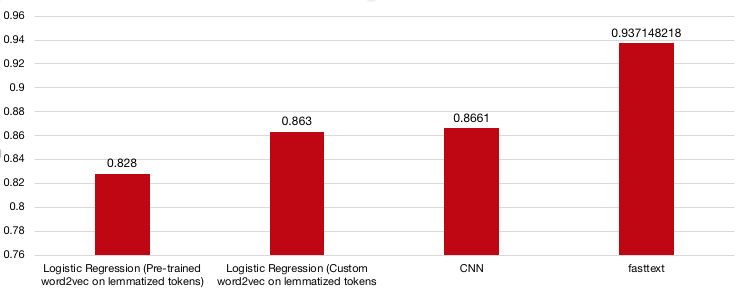

In [123]:
Image(filename='../img/model_comparison.png')